In [1]:
import tensorflow as tf

# List physical devices
devices = tf.config.list_physical_devices()
for device in devices:
    print(f"Device: {device}")

# Check if GPU is available
gpu = tf.config.list_physical_devices('GPU')
if gpu:
    print(f"Using GPU: {gpu}")
else:
    print("Using CPU")


Device: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
import tensorflow as tf
import os
import glob
import random
import math

# Load Data

## Function to load and preprocess images

In [49]:
def load_image(image_path, mask_path):
    # Load image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]

    return image, mask

## Function to build a 2D transformation matrix

In [50]:
def build_2d_transform_matrix(flip=None, offset=None, scale=None, rotate=None):
    transform = tf.eye(3)

    # Apply flip
    if flip and random.random() > 0.5:
        transform = tf.linalg.tensor_diag([flip, flip, 1.0]) @ transform
        # flip=-1 in x, flip=1 without change - flip=-1 in y - مقدار همگنی

    # Apply offset
    if offset:
        offset_x = random.uniform(-offset, offset)
        offset_y = random.uniform(-offset, offset)
        offset_matrix = tf.convert_to_tensor([[1, 0, offset_x],
                                              [0, 1, offset_y],
                                              [0, 0, 1]], dtype=tf.float32)
        transform = offset_matrix @ transform
        # if offset is a random number x (offset_x) , y (offset_y) generate ofset in range [-offset, offset]

    # Apply scale
    if scale:
        scale_x = 1.0 + random.uniform(-scale, scale)
        scale_y = 1.0 + random.uniform(-scale, scale)
        scale_matrix = tf.convert_to_tensor([[scale_x, 0, 0],
                                             [0, scale_y, 0],
                                             [0, 0, 1]], dtype=tf.float32)
        transform = scale_matrix @ transform
        # in range [1 - scale, 1 + scale]

    # Apply rotation
    if rotate:
        angle_rad = random.uniform(-rotate, rotate) * math.pi / 180
        rotation_matrix = tf.convert_to_tensor([[tf.cos(angle_rad), -tf.sin(angle_rad), 0],
                                                [tf.sin(angle_rad), tf.cos(angle_rad), 0],
                                                [0, 0, 1]], dtype=tf.float32)
        transform = rotation_matrix @ transform
        # in range [-rotate, rotate]

    # Extract the 2x3 part of the matrix and flatten it to [6]
    transform = transform[:2, :]
    transform = tf.reshape(transform, [6])

    # Append [0, 0] to make it [8] elements
    transform = tf.concat([transform, tf.constant([0.0, 0.0])], axis=0)

    return transform

## Function to apply data augmentation

In [51]:
def data_augmentation(image, mask, flip=None, offset=None, scale=None, rotate=None, noise=None):
    # Build the 2D transformation matrix
    transform_matrix = build_2d_transform_matrix(flip, offset, scale, rotate)

    # The transformation matrix needs to be in shape [1, 8]
    transform_matrix = tf.reshape(transform_matrix, [1, 8])

    # Apply affine transformation using ImageProjectiveTransformV2
    image_shape = tf.shape(image)[:2]
    image = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(image, 0),
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="BILINEAR")[0]

    mask = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(mask, 0), # convert to [1, height, width, channels]
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="NEAREST")[0]

    # Apply random noise
    if noise:
        noise_tensor = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise, dtype=tf.float32)
        image = tf.add(image, noise_tensor)

    return image, tf.cast(mask > 0.5, tf.float32) # in mask Converts all values ​​greater than 0.5 to 1 and all others to 0

## Shuffle and split the data

In [52]:
image_dir = "/Users/ghazalnazari/Documents/جزوات دانشگاه آلمان/Deep Learning/TechnoPro/LV-Segmentation-with-U-Net-main/DATA/frames/"
mask_dir = "/Users/ghazalnazari/Documents/جزوات دانشگاه آلمان/Deep Learning/TechnoPro/LV-Segmentation-with-U-Net-main/DATA/masks/"

In [53]:
# Get list of image and mask file paths
image_paths = glob.glob(os.path.join(image_dir, '*.png'))
mask_paths = [os.path.join(mask_dir, os.path.basename(im)) for im in image_paths]

In [54]:
image_paths[3], mask_paths[3]

('/Users/ghazalnazari/Documents/جزوات دانشگاه آلمان/Deep Learning/TechnoPro/LV-Segmentation-with-U-Net-main/DATA/frames/diastole5562.png',
 '/Users/ghazalnazari/Documents/جزوات دانشگاه آلمان/Deep Learning/TechnoPro/LV-Segmentation-with-U-Net-main/DATA/masks/diastole5562.png')

In [55]:
# Shuffle and split the data
N = len(image_paths)
ixRand = list(range(N)) # list of 0 to N−1
random.shuffle(ixRand)

train_image_paths = [image_paths[i] for i in ixRand[:round(N * 0.8)]]
train_mask_paths = [mask_paths[i] for i in ixRand[:round(N * 0.8)]]

val_image_paths = [image_paths[i] for i in ixRand[round(N * 0.8):]]
val_mask_paths = [mask_paths[i] for i in ixRand[round(N * 0.8):]]

In [56]:
#val_image_path

## Create TensorFlow Datasets

In [57]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

## Apply Loading and Preprocessing Functions

In [58]:
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) #map implement load_image on every element
train_dataset = train_dataset.map(lambda x, y: data_augmentation(x, y, flip=1, offset=0.1, scale=0.2, rotate=10, noise=0.1), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [59]:
# Check loaded data
for image, mask in train_dataset.take(1):
    print(image.shape, mask.shape)

(32, 112, 112, 3) (32, 112, 112, 1)


2024-09-13 22:03:38.062331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38640565..1.0022049].


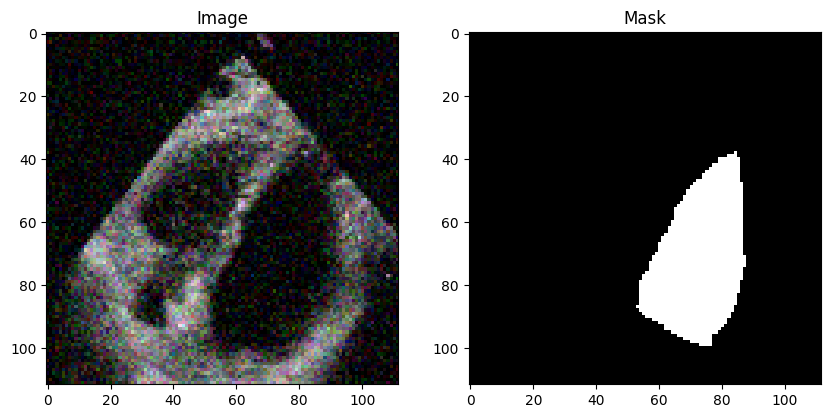

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3678784..1.0096285].


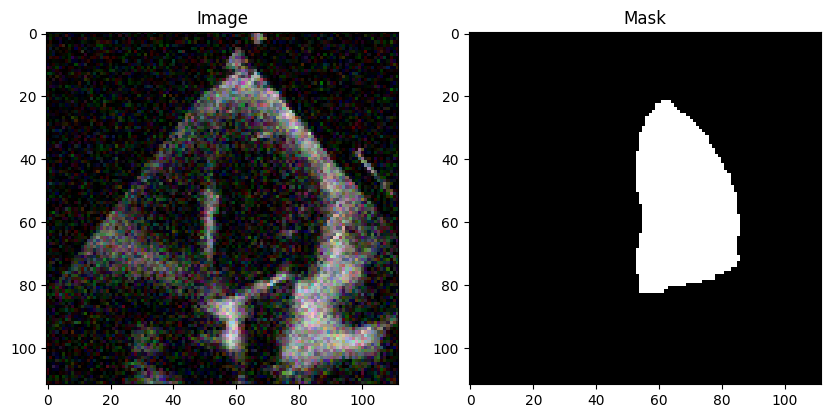

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40353486..1.0262659].


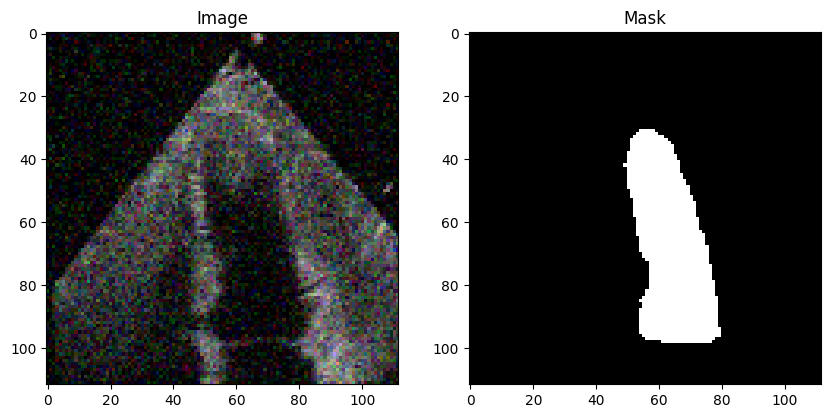

2024-09-13 22:03:38.965880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [60]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to display image and mask
def display_image_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.show()

# Take a batch of images and masks from the dataset
for images, masks in train_dataset.take(1):
    for i in range(3):  # Display 3 images and their masks
        image = images[i].numpy()
        mask = masks[i].numpy()
        display_image_mask(image, mask)

# Model ------> Attention U-Net

In [73]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D,Add, multiply, MaxPooling2D, UpSampling2D, concatenate, Activation, BatchNormalization, multiply, Add, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import tensorflow.keras.layers as L

In [74]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s
def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

In [75]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from keras import layers, Model

# attention_unet
def attention_unet(input_size=(256, 256, 3)):
    """
    Attention U-Net architecture.
    """
    #input
    inputs = tf.keras.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.5)(p1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.5)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.5)(p3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.5)(p4)

    #bottelneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.5)(c5)

    #decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.Dropout(0.5)(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.Dropout(0.5)(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.Dropout(0.5)(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs, name="Attention-UNET")
    return model


In [76]:
input_shape = (256, 256, 3)
model = attention_unet(input_shape)


In [77]:
model.summary()

Model: "Attention-UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128, 128,  │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │     73,856 │ dropout_16[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64, 64,    │          0 │ max_pooling2d_17… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │    295,168 │ dropout_17[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 32, 32,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32, 32,    │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ dropout_18[0][0]

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [78]:

def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Dice Coefficient metric to evaluate the segmentation performance.
    Args:
        y_true: Ground truth mask.
        y_pred: Predicted mask.
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Dice Coefficient value.
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [79]:
#Intersection over Union (IoU) or Jaccard Index



def iou_score(y_true, y_pred):
    """
    Intersection over Union (IoU) metric for segmentation.
    Args:
        y_true: Ground truth mask.
        y_pred: Predicted mask.
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        IoU value.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)


In [80]:
#Precision, Recall, and F1-Score

def precision(y_true, y_pred):
    """
    Calculate Precision.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum(y_pred_f) - tp
    return (tp + 1) / (tp + fp + 1)

def recall(y_true, y_pred):
    """
    Calculate Recall.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f) - tp
    return (tp + 1) / (tp + fn + 1)

def f1_score_metric(y_true, y_pred):
    """
    Calculate F1 Score.
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + 1e-6)

## Compile the Model with Metrics

In [81]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=[dice_coef, iou_score, precision, recall, f1_score_metric])


In [82]:
# Define callbacks with updated .keras format
checkpoint = ModelCheckpoint('attention_unet_best_model.keras',  
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               verbose=1, 
                               mode='min', 
                               restore_best_weights=True)


In [83]:
# Train the model using the datasets
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint, early_stopping])


Epoch 1/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - dice_coef: 0.6661 - f1_score_metric: 0.6661 - iou_score: 0.5349 - loss: 0.1549 - precision: 0.6417 - recall: 0.7161
Epoch 1: val_loss improved from inf to 0.16001, saving model to attention_unet_best_model.keras
502/502 ━━━━━━━━━━━━━━━━━━━━ 296s 571ms/step - dice_coef: 0.6663 - f1_score_metric: 0.6663 - iou_score: 0.5352 - loss: 0.1547 - precision: 0.6420 - recall: 0.7162 - val_dice_coef: 0.6132 - val_f1_score_metric: 0.6132 - val_iou_score: 0.4427 - val_loss: 0.1600 - val_precision: 0.4874 - val_recall: 0.8289
Epoch 2/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - dice_coef: 0.8569 - f1_score_metric: 0.8569 - iou_score: 0.7499 - loss: 0.0518 - precision: 0.8563 - recall: 0.8586
Epoch 2: val_loss improved from 0.16001 to 0.05172, saving model to attention_unet_best_model.keras
502/502 ━━━━━━━━━━━━━━━━━━━━ 289s 574ms/step - dice_coef: 0.8569 - f1_score_metric: 0.8570 - iou_score: 0.7499 - loss: 0.0518 - precision: 0.8563 - recall:

## Evaluate the Model 

In [84]:
results = model.evaluate(val_dataset, verbose=1)
print(f"Loss: {results[0]}")
print(f"Dice Coefficient: {results[1]}")
print(f"IoU Score: {results[2]}")
print(f"Precision: {results[3]}")
print(f"Recall: {results[4]}")
print(f"F1 Score: {results[5]}")


126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - dice_coef: 0.8914 - f1_score_metric: 0.8914 - iou_score: 0.8043 - loss: 0.0368 - precision: 0.8857 - recall: 0.8974
Loss: 0.03666560351848602
Dice Coefficient: 0.8915393352508545
IoU Score: 0.804559051990509
Precision: 0.8854765892028809
Recall: 0.8979200720787048
F1 Score: 0.8915417790412903


## Make Predictions

In [85]:
def display_images_and_masks(images, masks, predictions):
    num_images = len(images)
    plt.figure(figsize=(18, 4 * num_images))      #Adjust figure size based on the number of images
    
    for i in range(num_images):
        #Display the image
        plt.subplot(num_images,3 ,3 *i +1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')
        
        #Display the corresponding mask
        plt.subplot(num_images,3 ,3 *i +2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("True Maske")
        plt.axis('off')
        
        #Display the prediction
        plt.subplot(num_images,3 ,3 *i +3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
        
        
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


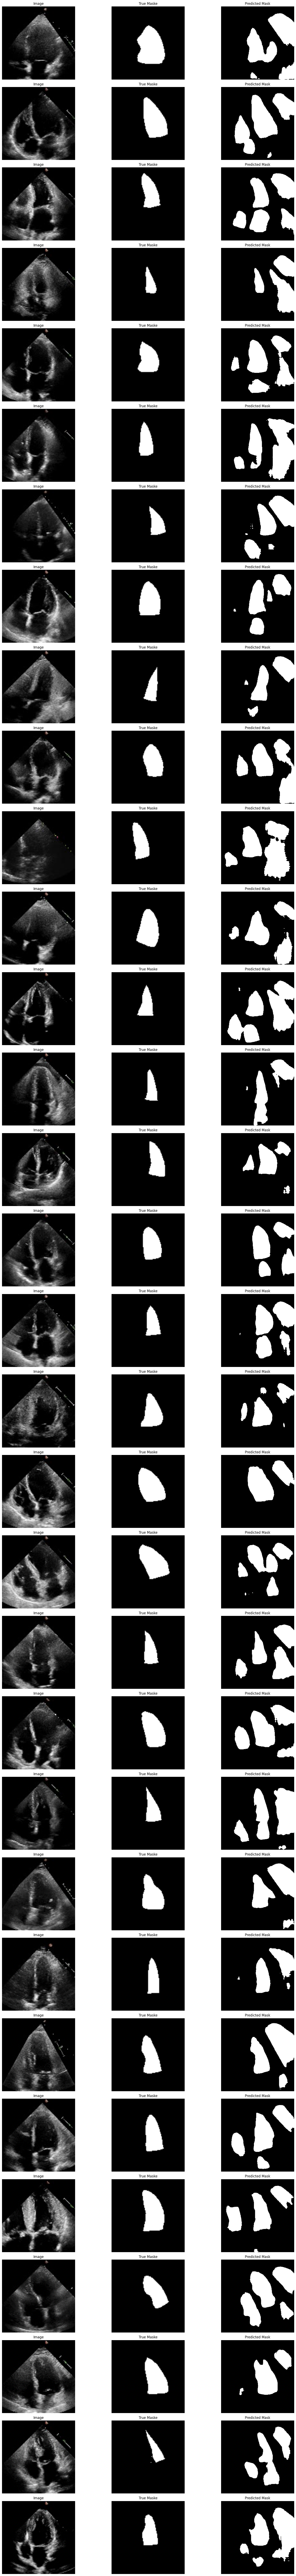

2024-09-12 22:16:30.659148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [70]:
import numpy as np
# Function to resize images and mask to the expected input size

def resize_images_and_masks(image, mask):
    image = tf.image.resize(image,(256,256))
    mask = tf.image.resize(mask, (256, 256))
    return image, mask

# Apply the resizing to the dataset
train_dataset = train_dataset.map(resize_images_and_masks)
val_dataset = val_dataset.map(resize_images_and_masks)

# Now when you take a batch , the images will be the correct size
for images, masks in val_dataset.take(1):
    predictions = model.predict(images)
    predictions = (predictions > 0.5).astype(np.uint8)     # Binarize predictions
    
    
    # Display a few predictions
    display_images_and_masks(images.numpy(), masks.numpy(), predictions)
    